In [251]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [252]:
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod', autocommit=True)

In [253]:
train = """
select basic.player_id,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
      -- box_view.home_away,
       basic.pts,
       basic.minutes_played,
       basic.fga,
       basic.3pa,
       basic.orb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       a_stats.pie,
       adv.offensive_rating,
       reg_avg.fg_a as tot_fg_a,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to,
       opp_team_pts.opp_pts,
       opp_team_pts.diff,
       misc.FBPS,
       misc.second_chance_pts

from (

     select b.game_hash,
            b.home_team as team,
            b.game_date,
            team.team_id as away_id,
            lu.season
     from box_score_map as b
     inner join game_date_lookup as lu on b.game_date = lu.day
     inner join team_info as team on b.away_team = team.team
     where b.game_date < current_date and
           lu.season > 2009 

     ) as box_view

inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
play_m.player_id = adv.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (box_view.season -1 = reg_avg.season) )
inner join points as opp_team_pts on box_view.away_id = opp_team_pts.team_id and box_view.season -1 = opp_team_pts.season
inner join team_misc_boxscore_stats as misc on ( (box_view.game_hash = misc.game_hash) and (box_view.team = misc.team) )
order by box_view.game_date desc;

"""

In [254]:
df = pd.read_sql(sql=train, con=conn, index_col=None)

In [255]:
def time_convert(minutes_played):
    time_list = minutes_played.split(':')
    try:
        return ((int(time_list[0]) * 60) + int(time_list[1]))
    except ValueError:
        return 0

In [256]:
def concat_drop(df, dummy_var_col, drop_list):
    for field in dummy_var_col:
        df = pd.concat([df, gen_dummby_var(df, field)], axis=1)
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [257]:
def gen_dummby_var(df, column):
    return pd.get_dummies(df[column], drop_first=True)

In [258]:
df.loc[:, 'minutes_played'] = df.loc[:, 'minutes_played'].apply(time_convert)

In [259]:
df.drop([ 'player_id', 'team', 'game_hash', 'game_date'], axis=1, inplace=True)
clean_df = df[df['minutes_played'] >= 600]
#clean_df = concat_drop(df[df['minutes_played'] >= 900], ['home_away'], [ 'player_id', 'team', 'game_hash', 'game_date'])

In [260]:
#clean_df.drop('Home', inplace=True, axis=1)
clean_df.head()
#group_df = clean_df.groupby(['game_date','team'])
#group_df.head()

,pts,minutes_played,fga,3pa,orb,trb,ast,stl,blk,tov,...,tot_reb,tot_ast,tot_blk,tot_stl,tot_pf,tot_to,opp_pts,diff,FBPS,second_chance_pts
1,0,705,2,2,0,1,1,0,2,0,...,5.4,1.1,0.6,0.3,2.5,1.0,108.0,-3.5,15,23
2,2,1196,4,2,3,5,4,1,0,1,...,3.5,4.8,0.4,1.3,2.5,2.4,108.0,-3.5,15,23
3,0,952,4,1,0,1,0,0,0,1,...,4.7,2.9,0.2,1.0,1.5,1.0,108.0,-3.5,15,23
4,11,1558,10,3,1,5,0,2,2,2,...,4.9,1.6,0.4,1.0,2.6,1.8,108.0,-3.5,15,23
5,15,1740,12,1,3,8,0,0,0,0,...,5.0,1.6,0.7,1.0,2.1,1.4,108.0,-3.5,15,23


In [261]:
#for group in group_df.groups:
 #   print(group)

In [262]:
clean_df = clean_df.fillna(0)

In [263]:
x = clean_df.loc[:, 'minutes_played':]
y = clean_df.loc[:, 'pts']

In [264]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.loc[:, 'minutes_played':], clean_df.loc[:, 'pts'], test_size=.33)

In [265]:
lm = LinearRegression()

In [266]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [267]:
predictions = lm.predict(X_test)

Text(0,0.5,'Predicted Y')

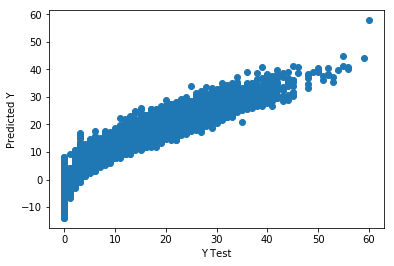

In [268]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

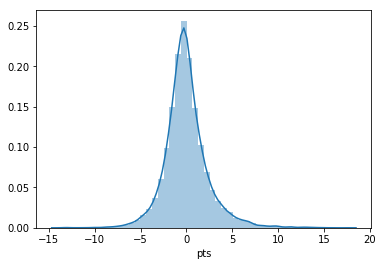

In [269]:
sns.distplot((y_test-predictions),bins=50);

In [270]:
coeffecients = pd.DataFrame(lm.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003089
fga,0.763102
3pa,0.061304
orb,-0.404672
trb,0.041226
ast,-0.303367
stl,0.024115
blk,0.036221
tov,0.035109
pf,-0.003367


In [271]:
lm.score(X_test, y_test)

0.9018848835416603

In [250]:
### Experimenting with Lasso regression

In [910]:
lasso = Lasso(alpha=0.0023101297000831605)  #Home: 0.00174333 - 0.00221222

In [911]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.0023101297000831605, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [912]:
predictions = lasso.predict(X_test)

Text(0,0.5,'Predicted Y')

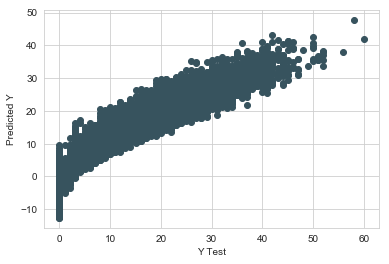

In [913]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

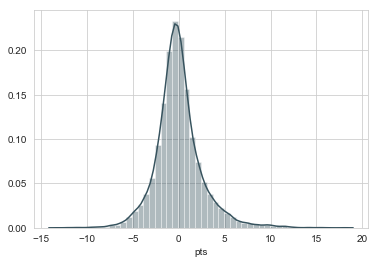

In [914]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.distplot(y_test-predictions, bins=50)

In [915]:
lasso.score(X_test, y_test)

0.89379683930393405

In [916]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.002463
fga,0.845509
3pa,0.057772
orb,-0.379354
trb,0.032231
ast,-0.281271
stl,0.028555
blk,0.037253
tov,0.131468
pf,-0.005475


In [917]:
#### Using Lasso cross-validation model

In [918]:
lasso_cv = LassoCV()

In [919]:
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [920]:
predictions_cv = lasso_cv.predict(X_test)

Text(0,0.5,'Predicted Y')

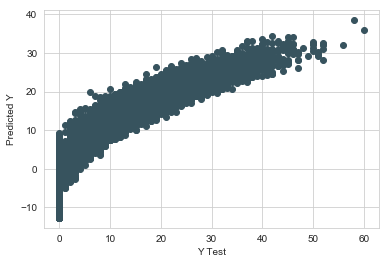

In [921]:
plt.scatter(y_test,predictions_cv)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

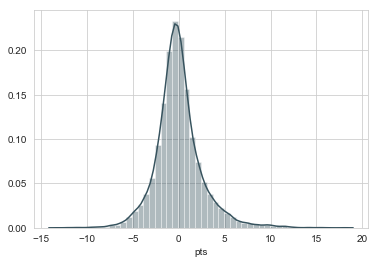

In [922]:
sns.distplot(y_test-predictions, bins=50)

In [923]:
lasso_cv.score(X_test, y_test)

0.85434119571395317

In [924]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.002463
fga,0.845509
3pa,0.057772
orb,-0.379354
trb,0.032231
ast,-0.281271
stl,0.028555
blk,0.037253
tov,0.131468
pf,-0.005475


In [925]:
### optimizing alpha value in Lasso regression

In [297]:
alphas = np.logspace(-4, -1, 50)
#alphas = np.linspace(.001, .999, 100) #0.00464159
alphas

array([ 0.0001    ,  0.00011514,  0.00013257,  0.00015264,  0.00017575,
        0.00020236,  0.000233  ,  0.00026827,  0.00030888,  0.00035565,
        0.00040949,  0.00047149,  0.00054287,  0.00062506,  0.00071969,
        0.00082864,  0.0009541 ,  0.00109854,  0.00126486,  0.00145635,
        0.00167683,  0.0019307 ,  0.002223  ,  0.00255955,  0.00294705,
        0.00339322,  0.00390694,  0.00449843,  0.00517947,  0.00596362,
        0.00686649,  0.00790604,  0.00910298,  0.01048113,  0.01206793,
        0.01389495,  0.01599859,  0.0184207 ,  0.02120951,  0.02442053,
        0.02811769,  0.03237458,  0.03727594,  0.04291934,  0.04941713,
        0.05689866,  0.06551286,  0.0754312 ,  0.08685114,  0.1       ])

In [298]:
scores = np.empty_like(alphas)

In [299]:
for i, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)

In [300]:
lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(x, y)
cv_score = lasso_cv.score(x, y)
cv_alpha = lasso_cv.alpha_
cv_alpha, cv_score, lasso_cv.coef_, lasso_cv.intercept_

(0.0025595479226995358,
 0.90069202892991251,
 array([ 0.00308817,  0.76766656,  0.05879458, -0.39461982,  0.03528385,
        -0.30203406,  0.01950961,  0.0295862 ,  0.02940875, -0.00134643,
         0.07557706,  0.25060729,  0.06188472,  0.00843802,  0.09046376,
        -0.08499421,  0.00241469,  0.48274729,  0.0421303 ,  0.00497784,
         0.11506393, -0.00258712, -0.15427611, -0.        , -0.00468705,
        -0.00492849,  0.00393041, -0.0180678 ]),
 -21.192074513899492)

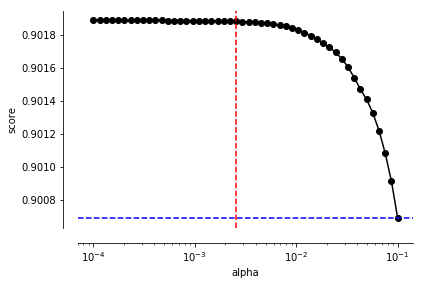

In [301]:
plt.plot(alphas, scores, '-ko')
plt.axhline(cv_score, color='b',ls='--')
plt.axvline(cv_alpha, color='r', ls='--')
plt.xlabel('alpha')
plt.ylabel('score')
plt.xscale('log')
sns.despine(offset=15)

In [302]:
predictions = lasso_cv.predict(X_test)

In [303]:
lasso_cv.score(x, y)

0.90069202892991251

In [304]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.68423339645
MSE: 5.75572996321
RMSE: 2.39911024407


In [305]:
np.amax(scores)

0.90188484774229172

In [306]:
np.take(alphas, np.argmax(scores))

0.0001

Text(0,0.5,'predictions')

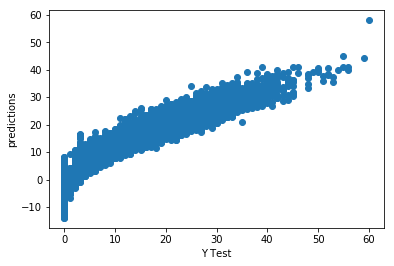

In [307]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('predictions')